In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# 데이터 불러오기

In [2]:
df_train = pd.read_csv('./train.csv')
df_test  = pd.read_csv('./test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 샘플 갯수와 피쳐 확인

In [5]:
print('ID칼럼 삭제전 train 데이터 shape:{}'.format(df_train.shape))
print('ID칼럼 삭제전 test 데이터 shape:{}'.format(df_test.shape))

#------ ID칼럼 따로 저장
train_ID = df_train['Id'] 
test_ID  = df_test['Id']
#-----------------------

df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

print()

print('ID칼럼 삭제후 train 데이터 shape:{}'.format(df_train.shape))
print('ID칼럼 삭제후 train 데이터 shape:{}'.format(df_test.shape))

ID칼럼 삭제전 train 데이터 shape:(1460, 81)
ID칼럼 삭제전 test 데이터 shape:(1459, 80)

ID칼럼 삭제후 train 데이터 shape:(1460, 80)
ID칼럼 삭제후 train 데이터 shape:(1459, 79)


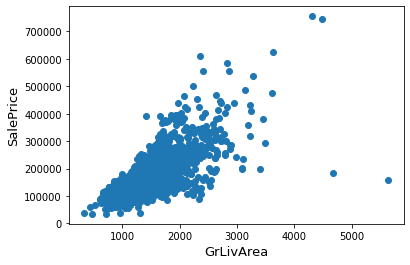

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#----- 우측 아랫쪽 영역에서 2개의 아웃라이어 발견

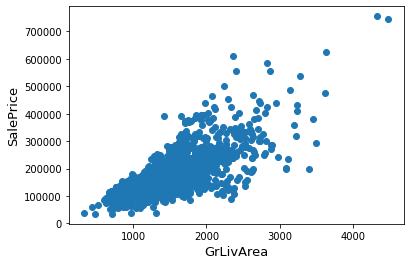

In [7]:
#----- 2개의 아웃라이어 삭제
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

#----- 아웃라이어 삭제후 확인
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#----- 아웃라이어 제거는 안전한 방법은 아니며, 위 두개의 아웃라이어가 매우 크고 부정적이다라는 주관적인 판단하에 삭제를 진행하였다.

# 타겟변수


 mu = 180932.92 and sigma = 79467.79 



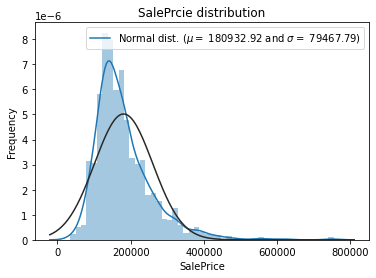

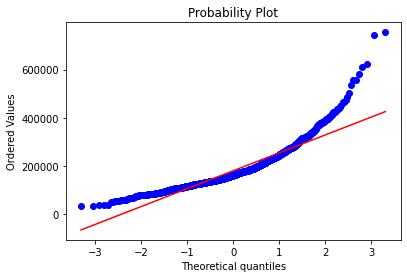

In [8]:
sns.distplot(df_train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(df_train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f} \n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma, loc='best')])
plt.ylabel('Frequency')
plt.title('SalePrcie distribution')

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

#----- 타겟변수가 왼쪽으로 치우쳐저있는 상태,  변수를 수정하여 정규분포에 가깝게 만들어야한다.

# 타겟변수의 로그치환


 mu = 12.02 and sigma = 0.40



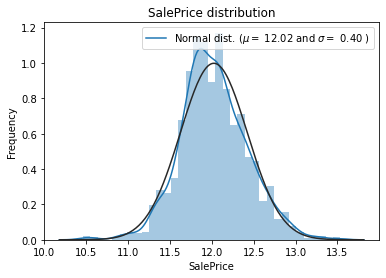

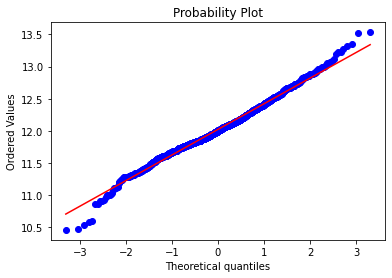

In [9]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

#----- 왜도가 수정되어 정규분포성을 어느정도 보여준다.

In [10]:
h_train = df_train.shape[0] #-----행
h_test  = df_test.shape[0]

# 타겟변수를 제외한 독립변수로 이루어진 DF

In [11]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train['SalePrice'].values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [12]:
all_data_na = (all_data.isna().sum()/len(all_data))*100
all_data_na.drop(all_data_na[all_data_na == 0].index, inplace=True)
all_data_na=all_data_na.sort_values(ascending=False)
null_data = pd.DataFrame({'null': all_data_na})
null_data

,null
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent null data by feature')

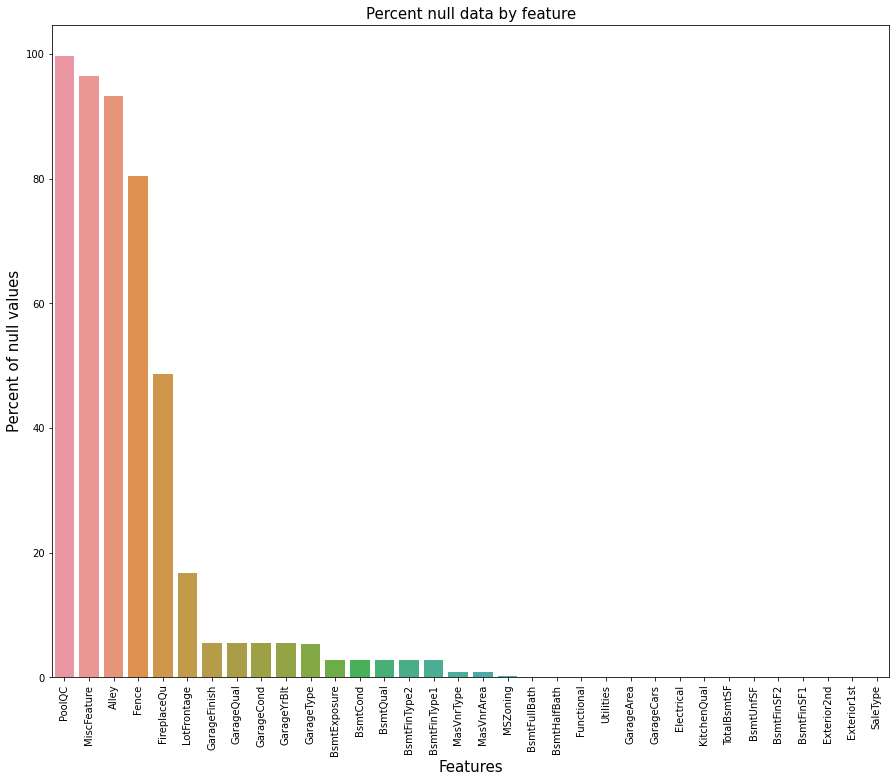

In [14]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of null values', fontsize=15)
plt.title('Percent null data by feature', fontsize=15)

<AxesSubplot:>

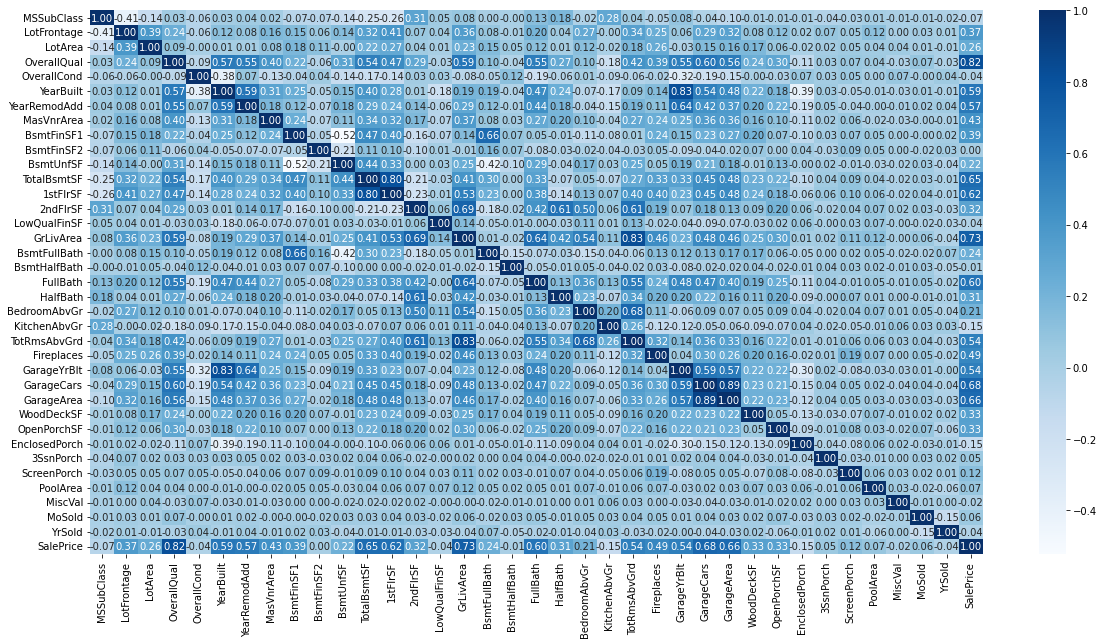

In [20]:
plt.subplots(figsize=(20,10))
sns.heatmap(df_train.corr(), fmt='.2f', annot=True, cmap='Blues')

In [24]:
#----- 데이터 설명서에서 아래 칼럼의 결측값은 '없음'이라고 설명한다.
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

#----- 주택 부동산과 연결된 각 거리의 면적이 이웃의 다른 주택과 비슷한 면적을 가진 가능성이 높아 결측값을 이웃의 중앙값 LotFrontage로 채운다.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#----- 누락된 데이터를 없음으로 대체한다.
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
#----- 결측 데이터를 0으로 대체한다.(차고 없음 = 해당 차고에 차량이 없음)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
#----- 지하실이 없는 경우 결측값이 0일 가능성이 높다.
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

#----- 지하실과 관련된 특징에 대해 결측값은 지하실이 없다는 것을 의미한다.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
#----- 결측값은 집들에 대한 석조 외피를 의미하지 않을 가능성이 크다.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

#----- RL은 가장 일반적인 값으로 결측값을 'RL'로 채울 수 있습니다.
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#----- 이 범주형 칼럼의 경우, "NoSewa" 1개와 NA 2개를 제외한 모든 레코드는 "AllPub"이다. 
#----- "NoSewa"가 있는 집이 교육 세트에 있으므로, 이 기능은 예측 모델링에 도움이 되지 않으므로 안전하게 제거할 수 있다.
all_data = all_data.drop(['Utilities'], axis=1)

#----- 결측값이 전형적인 것을 의미한다고 기술되어 있다.
all_data["Functional"] = all_data["Functional"].fillna("Typ")

#---- 소수의 결측값만을 가져, 가장 빈번한 값으로 대체한다.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# 결측값 수정 후 확인

In [26]:
all_data_na = (all_data.isna().sum()/len(all_data))*100
all_data_na.drop(all_data_na[all_data_na == 0].index, inplace=True)
all_data_na=all_data_na.sort_values(ascending=False)
null_data = pd.DataFrame({'null': all_data_na})
null_data

,null


# 수치로 표현된 범주형 데이터를 str로 변환

In [31]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [34]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
       
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


# 칼럼 추가

In [36]:
#집값을 결정짓는 데는 면적과 관련된 특징이 매우 중요하기 때문에 각 주택의 지하, 1층, 2층 면적의 총 면적에 해당하는 특징을 하나 더 추가한다.
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 첨도 확인 및 변환

In [49]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\n numerical features의 왜도: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


 numerical features의 왜도: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [53]:
#----- 스키피 함수 boxcox1p를 사용
skewness = skewness[abs(skewness) > 0.75]
print("Box Cox 변환에는 {}개의 왜도가 존재한다.".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

Box Cox 변환에는 59개의 왜도가 존재한다.


# 더비변수 생성

In [73]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [74]:
ntrain, ntest 

(1458, 1459)

In [75]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.926,1.031,1.199,0.739,0.739,0.834,0.572,0.901,0.858,1.158,...,0,0,0,1,0,0,0,0,1,0
1,0.876,1.041,1.202,0.739,0.739,0.834,0.572,0.890,0.901,1.158,...,0,0,0,1,0,0,0,0,1,0
2,0.926,1.034,1.206,0.739,0.739,0.572,0.572,0.901,0.858,1.158,...,0,0,0,1,0,0,0,0,1,0
3,0.932,1.028,1.202,0.739,0.739,0.572,0.572,0.901,0.858,1.157,...,0,0,0,1,1,0,0,0,0,0
4,0.926,1.043,1.212,0.739,0.739,0.572,0.572,0.911,0.858,1.158,...,0,0,0,1,0,0,0,0,1,0


# 교차검증전략

In [76]:
#----- cross_val_score 함수를 사용 
#----- 셔플 속성을 가지고 있지 않으며, 교차 검증 전에 데이터 세트를 셔플하기 위해 코드 한 줄을 추가

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [78]:
#----- LASSO Regression
#----- 특이치에 매우 민감, 조금 더 견고하게 하기 위해서 sklearn의 Robustscaler() 방법을 사용
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#----- Elastic Net Regression 
#----- 다시한번 특이치의 민감도를 견고하게 하기 위해서
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#----- Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#----- Gradient Boosting Regression
#----- 특이치의 민감도를 견고하게 만드는 허버 손실 포함
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#----- XGBoost 
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
#----- LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [84]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1175 (0.0088)

ElasticNet score: 0.1174 (0.0087)

Kernel Ridge score: 0.1900 (0.0096)

Gradient Boosting score: 0.1167 (0.0084)

[21:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:38:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:38:25] WARNING: C:/Us

In [87]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [88]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1186 (0.0079)



In [89]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [90]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1094 (0.0076)


In [91]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [92]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0742685571120838


In [93]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[21:46:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.0788027351714493


In [94]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.0714845163786646


In [97]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07222271044840388


In [98]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [99]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)